<a href="https://colab.research.google.com/github/VieuxRoblochon/Deep-Image-Prior/blob/master/pytorch_nn_kws.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/khannay/paramfittorchdemo/blob/main/nbs/00_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run Notebook Imports

In [2]:
#| hide 
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive')

!pip install torchdiffeq
import torch
import torch.nn as nn
import numpy as np
from scipy.interpolate import interp1d
import torch 
import torch.nn as nn
from torchdiffeq import odeint as odeint
import pylab as plt
from torch.utils.data import Dataset, DataLoader
from typing import Callable, List, Tuple, Union, Optional
from pathlib import Path  
import pandas as pd
import math

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!
/bin/bash: nvidia-smi: command not found


# Differential Equations as a Pytorch Neural Network Layer

> How to use differential equations layers in pytorch

## What is the problem we are trying to solve? 

Let's say we have some time series data y(t) that we want to model with a differential equation. The data takes the form of a set of observations yᵢ at times tᵢ. Based on some domain knowledge of the underlying system we can write down a differential equation to approximate the system. 

In the most general form this takes the form:

$$\begin{align}
\frac{dy}{dt} = f(y,t;\theta)  \\
y(t_0) = y_0 
\end{align}$$

where $y$ is the state of the system, $t$ is time, and $\theta$ are the parameters of the model. In this post we will assume that the parameters $\theta$ are unknown and we want to learn them from the data. 

## Models

The first step of our modeling process is to define the model. For differential equations this means we must choose a form for the function $f(y,t;\theta)$ and a way to represent the parameters $\theta$. We also need to do this in a way that is compatible with pytorch. 

This means we need to encode our function as a torch.nn.Module class. As you will see this is pretty easy and only requires defining two methods. Lets get started with the first of out three example models. 

## Snowmelt

The code below defines the KinematicStorageModel_Lumped class, which represents the lumped kinematic storage model. The model's parameters are initialized in the constructor, and the forward method computes the derivative of h with respect to time t.

The aquifer parameters, such as L, fp, w, and Ks, are defined, and the slope alpha is calculated based on the Slope variable.

The time points are defined using torch.arange with the specified t_start, t_end, and step_size.

The infiltration from snowmelt I is obtained from the data, and the evapotranspiration E is set to zero for all time points.

The model is instantiated with the parameters, and the initial conditions are set to zero for each time point.

The ODE is solved using odeint with the dopri5 method, and the solutions are converted to a numpy array for further processing.

Finally, the depth variation is plotted over time using matplotlib.

In [3]:
import pandas as pd
# Load infiltration data for I (m/s) from: /content/drive/MyDrive/Colab Notebooks/snowmelt_5-1-2023.csv
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/snowmelt_5-1-2023.csv')
data

,Date,snowmelt (m/s)
0,5/1/2023 12:00,0.000000e+00
1,5/1/2023 12:05,0.000000e+00
2,5/1/2023 12:10,8.470000e-07
3,5/1/2023 12:15,0.000000e+00
4,5/1/2023 12:20,0.000000e+00
...,...,...
427,5/2/2023 23:35,0.000000e+00
428,5/2/2023 23:40,0.000000e+00
429,5/2/2023 23:45,0.000000e+00
430,5/2/2023 23:50,0.000000e+00


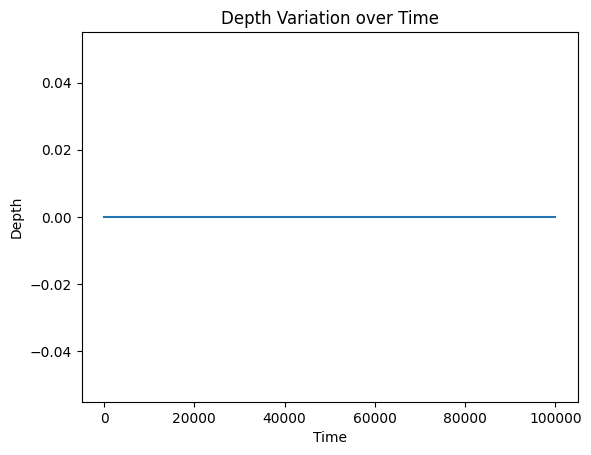

In [20]:
class KinematicStorageModel_Lumped(nn.Module):
    def __init__(self, L, fp, w, alpha, Ks, I, E):
        super().__init__()
        self.L = L
        self.fp = fp
        self.w = w
        self.alpha = alpha
        self.Ks = Ks
        self.I = I
        self.E = E

    def forward(self, t, h):
        # Compute the derivative of h with respect to t
        dh_dt = torch.zeros_like(h)
        dh_dt = (self.I - self.E) * (self.L * self.fp * self.w) - h * self.w * self.Ks * torch.sin(self.alpha)
        return dh_dt

# Aquifer parameters of receiving snowmelt infiltration 
L = 10000                        # Length of the aquifer (m)
w = 1
fp = torch.tensor(0.3)           # Porosity of the soil
Ks = torch.tensor(4.566e-5)      # Saturated Hydraulic Conductivity (m/s)

# Calculate slope in radians
Slope = torch.tensor(0.4)
alpha = torch.atan(Slope)

# Define the time points
t_start = 0
t_end = 100000
step_size = 300  # data has a timestep of 5 minutes or 300 seconds

ts = torch.arange(t_start, t_end, step_size).float()

# Infiltration from snowmelt
I = torch.tensor(data['snowmelt (m/s)'].values[:len(ts)], dtype=torch.float32)
E = torch.zeros_like(I)

# Define the model
model = KinematicStorageModel_Lumped(L, fp, w, alpha, Ks, I, E)

# Define initial conditions
initial_conditions = torch.zeros((len(ts),))  # Initial conditions for h
initial_conditions[0] = 0.0  # Set the initial condition for the first time point

# Solve the ODE
sol = odeint(model, initial_conditions, ts, method='dopri5').detach()

# Convert solutions to numpy array for further processing
solutions = np.array(sol)
time_values = ts.numpy()

# Plot depth with time
plt.plot(time_values, solutions[:, 0])
plt.xlabel('Time')
plt.ylabel('Depth')
plt.title('Depth Variation over Time')
plt.show()


# Explict integration without odeint

<ipython-input-12-a2730edef206>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  I = torch.tensor(I.max())  # Varying values of I for this example


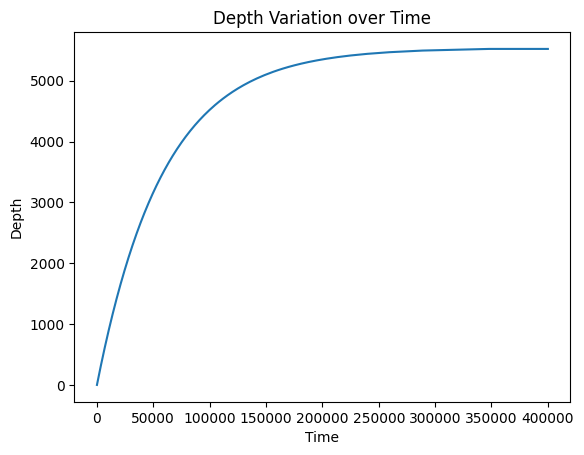

In [ ]:
import torch
import matplotlib.pyplot as plt

class KinematicStorageModel_Lumped(nn.Module):
    def __init__(self, L, fp, w, alpha, Ks, I, E):
        super().__init__()
        self.L = L
        self.fp = fp
        self.w = w
        self.alpha = alpha
        self.Ks = Ks
        self.I = I
        self.E = E

    def forward(self, t, h):
        dh_dt = (self.I.max() - self.E) * (self.L * self.fp * self.w) - h * self.w * self.Ks * torch.sin(self.alpha)
        return dh_dt

# Aquifer parameters of receiving snowmelt infiltration 
L = 10000                        # Length of the aquifer (m)
w = 1
fp = torch.tensor(0.3)           # Porosity of the soil
Ks = torch.tensor(4.566e-5)      # Saturated Hydraulic Conductivity (m/s)
Slope = torch.tensor(0.4)
alpha = torch.atan(Slope)


# Define the time points
t_start = 0
t_end = 100000
step_size = 300  # data has a timestep of 5 minutes or 300 seconds

ts = torch.arange(t_start, t_end, step_size).float()

# Infiltration from snowmelt
I = torch.tensor(data['snowmelt (m/s)'].values[:len(ts)], dtype=torch.float32)
E = torch.zeros_like(I)

I = torch.tensor(I.max())  # Varying values of I for this example
E = torch.tensor(0.0)

# Define the model
model = KinematicStorageModel_Lumped(L, fp, w, alpha, Ks, I, E)

# Define the initial condition
h_initial = torch.tensor(0.0)

# Define the time points
t_start = 0
t_end = 0.4e6
dt = 1  # Time step size
num_steps = int((t_end - t_start) / dt)
time_values = torch.linspace(t_start, t_end, num_steps)

# Generate data by repeatedly calling the forward method
h_values = []
h = h_initial
for t in time_values:
    model.I = I
    h_values.append(h.item())
    dh_dt = model.forward(t, h)
    h = h + dh_dt * dt

# Plot depth with time
plt.plot(time_values, h_values)
plt.xlabel('Time')
plt.ylabel('Depth')
plt.title('Depth Variation over Time')
plt.show()


## Integrating dh/dt with odeint
The important changes that resulted in odeint working are as follows:

Importing odeint from torchdiffeq: from torchdiffeq import odeint. odeint is a function provided by the torchdiffeq package that allows solving ordinary differential equations.

Defining the function for odeint: Instead of directly using the forward method of the KinematicStorageModel_Lumped class, we define a separate function ode_func(t, h) that takes the current time t and the current state h as inputs and returns the derivative dh_dt using model.forward(t, h).

Calling odeint with the defined function: Instead of explicitly integrating h using h = h + dh_dt * dt, we pass the ode_func as the first argument to odeint. The initial condition h_initial, time values time_values, and the desired integration method (method='dopri5') are also passed as arguments to odeint.

By making these changes, we utilize the odeint function from torchdiffeq to numerically solve the differential equation defined by the KinematicStorageModel_Lumped class. This allows for more accurate and efficient integration compared to explicit integration methods.

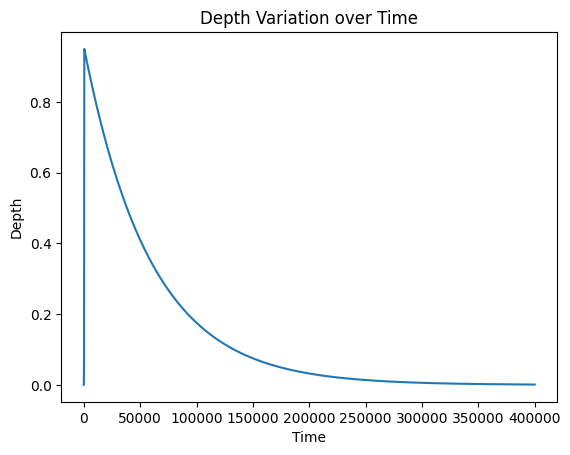

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchdiffeq import odeint

class KWS(nn.Module):
    def __init__(self, L, fp, w, alpha, Ks, I, E):
        super().__init__()
        self.L = L
        self.fp = fp
        self.w = w
        self.alpha = alpha
        self.Ks = Ks
        self.I = I
        self.E = E

    def forward(self, t, h):
        dh_dt = (self.I - self.E) * (self.L * self.fp * self.w) - h * self.w * self.Ks * torch.sin(self.alpha)
        return dh_dt

# Aquifer parameters of receiving snowmelt infiltration 
L = 10000                        # Length of the aquifer (m)
w = 1
fp = torch.tensor(0.3)           # Porosity of the soil
Ks = torch.tensor(4.566e-5)      # Saturated Hydraulic Conductivity (m/s)
Slope = torch.tensor(0.4)
alpha = torch.atan(Slope)

# Define time points
t_start = 0
t_end = 0.4e6
dt = 1  # Time step size
num_steps = int((t_end - t_start) / dt)
time_values = torch.linspace(t_start, t_end, num_steps)

I = torch.tensor(data['snowmelt (m/s)'].values[:len(time_values)], dtype=torch.float32)
#I = time_values.clone().detach()*I.max()
E = torch.tensor(0.0)

# Define the model
model = KinematicStorageModel_Lumped(L, fp, w, alpha, Ks, I, E)

# Define the initial condition
h_initial = torch.tensor(0.0)


def ode_func(t, h):
    index = min(int(t.item()), len(I) - 1)
    model.I = I[index].unsqueeze(0)  # Add unsqueeze to match tensor shape
    return model.forward(t, h)

# Solve the ODE using odeint
sol = odeint(ode_func, h_initial, time_values, method='rk4')

# Get the depth values from the solution
h_values = sol.numpy().flatten()

# Plot depth with time
plt.plot(time_values, h_values)
plt.xlabel('Time')
plt.ylabel('Depth')
plt.title('Depth Variation over Time')
plt.show()


# Generate data to train on

### van Der Pol Oscillator (VDP)

We can define a differential equation system using the <i> torch.nn.Module </i>  class where the parameters are created using the <i> torch.nn.Parameter </i>
declaration. This lets pytorch know that we want to accumulate gradients for those parameters. We can also include fixed parameters (don't want to fit these) by just not wrapping them with this declaration. 

The first example we will use is the classic VDP oscillator which is a nonlinear oscillator with a single parameter $\mu$. The differential equations for this system are:

$$\begin{align}
\frac{dX}{dt} &= \mu(x-\frac{1}{3}x^3-y)  \\
\frac{dY}{dt} &= \frac{x}{\mu}  \\
\end{align}$$

where $X$ and $Y$ are the state variables. The VDP model is used to model everything from electronic circuits to cardiac arrhythmias and circadian rhythms. We can define this system in pytorch as follows:


In [ ]:
#| exports 

class VDP(nn.Module):
    """ 
    Define the Van der Pol oscillator as a PyTorch module.
    """
    def __init__(self, 
                 mu: float, # Stiffness parameter of the VDP oscillator
                 ):
        super().__init__() 
        self.mu = torch.nn.Parameter(torch.tensor(mu)) # make mu a learnable parameter
        
    def forward(self, 
                t: float, # time index
                state: torch.TensorType, # state of the system first dimension is the batch size
                ) -> torch.Tensor: # return the derivative of the state
        """ 
            Define the right hand side of the VDP oscillator.
        """
        x = state[..., 0] # first dimension is the batch size
        y = state[..., 1]
        dX = self.mu*(x-1/3*x**3 - y)
        dY = 1/self.mu*x
        # trick to make sure our return value has the same shape as the input
        dfunc = torch.zeros_like(state) 
        dfunc[..., 0] = dX
        dfunc[..., 1] = dY
        return dfunc
    
    def __repr__(self):
        """Print the parameters of the model."""
        return f" mu: {self.mu.item()}"
    
    

You only need to define the dunder init method (__init__) and the forward method. I added a string method __repr__ to pretty print the parameter. The key point here is how we can translate from the differential equation to torch code in the forward method. This method needs to define the right-hand side of the differential equation. 

Let's see how we can integrate this model using the odeint method from torchdiffeq:

In [ ]:
vdp_model = VDP(mu=0.5)

# Create a time vector, this is the time axis of the ODE
ts = torch.linspace(0,30.0,1000)
# Create a batch of initial conditions 
batch_size = 30
# Creates some random initial conditions
initial_conditions = torch.tensor([0.01, 0.01]) + 0.2*torch.randn((batch_size,2))

# Solve the ODE, odeint comes from torchdiffeq
sol = odeint(vdp_model, initial_conditions, ts, method='dopri5').detach().numpy()


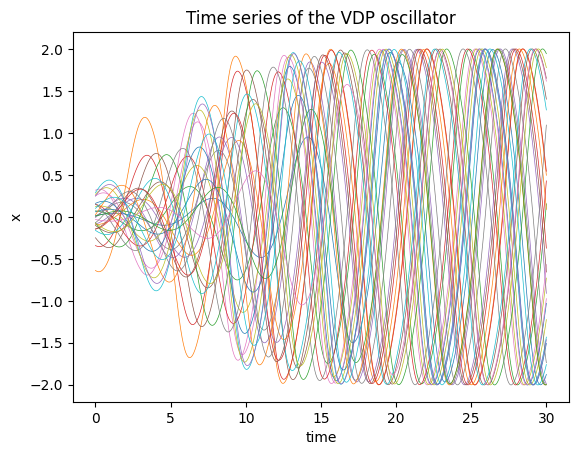

In [ ]:
plt.plot(ts, sol[:,:,0], lw=0.5);
plt.title("Time series of the VDP oscillator");
plt.xlabel("time");
plt.ylabel("x");

Here is a phase plane plot of the solution (a phase plane plot of a parametric plot of the dynamical state). 

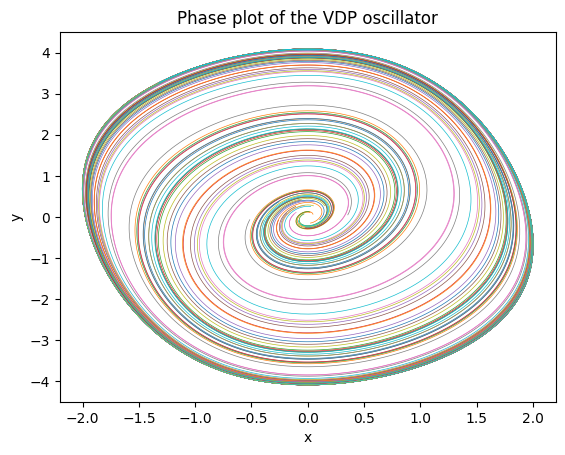

In [ ]:
# Check the solution
plt.plot(sol[:,:,0], sol[:,:,1], lw=0.5);
plt.title("Phase plot of the VDP oscillator");
plt.xlabel("x");
plt.ylabel("y");

The colors indicate the 30 seperate trajectories in our batch. The solution comes back as a torch tensor with dimensions (time_points, batch number, dynamical_dimension). 

In [ ]:
sol.shape

(1000, 30, 2)

### Lotka Volterra Predator Prey equations 

As another example we create a module for the Lotka Volterra predator-prey equations. In the Lotka-Volterra (LV) predator-prey model, there are two primary variables: the population of prey ($x$) and the population of predators ($y$). The model is defined by the following equations:

$$\begin{align}
\frac{dx}{dt} &= \alpha x - \beta xy \\
\frac{dy}{dt} &= -\delta y + \gamma xy \\
\end{align}$$

The population of prey ($x$) represents the number of individuals of the prey species present in the ecosystem at any given time. The population of predators ($y$) represents the number of individuals of the predator species present in the ecosystem at any given time.

In addition to the primary variables, there are also four parameters that are used to describe various ecological factors in the model:

$\alpha$ represents the intrinsic growth rate of the prey population in the absence of predators.
$\beta$ represents the predation rate of the predators on the prey. 
$\gamma$ represents the death rate of the predator population in the absence of prey.
$\delta$ represents the efficiency with which the predators convert the consumed prey into new predator biomass.

Together, these variables and parameters describe the dynamics of predator-prey interactions in an ecosystem and are used to mathematically model the changes in the populations of prey and predators over time.

In [ ]:
#| exports


class LotkaVolterra(nn.Module):
    """ 
     The Lotka-Volterra equations are a pair of first-order, non-linear, differential equations
     describing the dynamics of two species interacting in a predator-prey relationship.
    """
    def __init__(self,
                 alpha: float = 1.5, # The alpha parameter of the Lotka-Volterra system
                 beta: float = 1.0, # The beta parameter of the Lotka-Volterra system
                 delta: float = 3.0, # The delta parameter of the Lotka-Volterra system
                 gamma: float = 1.0 # The gamma parameter of the Lotka-Volterra system
                 ) -> None:
        super().__init__()
        self.model_params = torch.nn.Parameter(torch.tensor([alpha, beta, delta, gamma]))
        
        
    def forward(self, t, state):
        x = state[...,0]      #variables are part of vector array u 
        y = state[...,1]
        sol = torch.zeros_like(state)
        
        #coefficients are part of tensor model_params
        alpha, beta, delta, gamma = self.model_params    
        sol[...,0] = alpha*x - beta*x*y
        sol[...,1] = -delta*y + gamma*x*y
        return sol
    
    def __repr__(self):
        return f" alpha: {self.model_params[0].item()}, \
            beta: {self.model_params[1].item()}, \
                delta: {self.model_params[2].item()}, \
                    gamma: {self.model_params[3].item()}"


This follows the same pattern as the first example, the main difference is that we now have four parameters and store them as a model_params tensor. Here is the integration and plotting code for the predator-prey equations. 

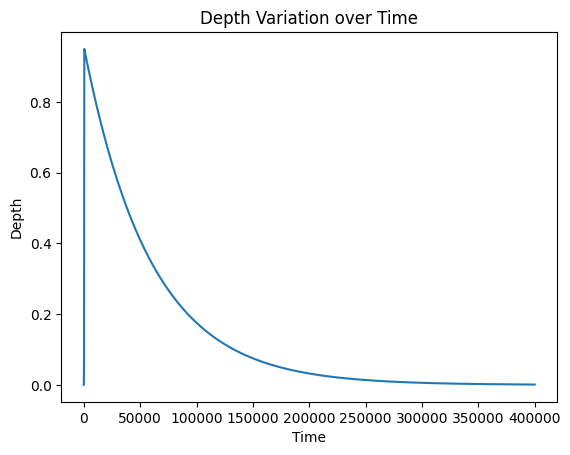

In [ ]:
L = 10000                        # Length of the aquifer (m)
w = 1
fp = torch.tensor(0.3)           # Porosity of the soil
Ks = torch.tensor(4.566e-5)      # Saturated Hydraulic Conductivity (m/s)
Slope = torch.tensor(0.4)
alpha = torch.atan(Slope)

# Define time points
t_start = 0
t_end = 0.4e6
dt = 1  # Time step size
num_steps = int((t_end - t_start) / dt)
time_values = torch.linspace(t_start, t_end, num_steps)

I = torch.tensor(data['snowmelt (m/s)'].values[:len(time_values)], dtype=torch.float32)
#I = time_values.clone().detach()*I.max()
E = torch.tensor(0.0)

# Define the initial condition
h_initial = torch.tensor(0.0)


def ode_func(t, h):
    index = min(int(t.item()), len(I) - 1)
    model.I = I[index].unsqueeze(0)  # Add unsqueeze to match tensor shape
    return model.forward(t, h)

# Solve the ODE using odeint
sol = odeint(ode_func, h_initial, time_values, method='rk4')

# Get the depth values from the solution
h_values = sol.numpy().flatten()

# Plot depth with time
plt.plot(time_values, h_values)
plt.xlabel('Time')
plt.ylabel('Depth')
plt.title('Depth Variation over Time')
plt.show()

# Kinematic Wave Storage

In [ ]:
I.max()

tensor(3.1300e-05)

# Generate perturbation of fp

In [ ]:
# Generate perturbations of fp
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchdiffeq import odeint


class KWS(nn.Module):
    def __init__(self, L, fp, w, alpha, Ks, I, E):
        super().__init__()
        self.L = L
        self.fp = fp
        self.w = w
        self.alpha = alpha
        self.Ks = Ks
        self.I = I
        self.E = E

    def forward(self, t, h):
        dh_dt = (self.I - self.E) * (self.L * self.fp * self.w) - h * self.w * self.Ks * torch.sin(self.alpha)
        return dh_dt


if __name__ == "__main__":
    # Aquifer parameters of receiving snowmelt infiltration
    L = 10000                      # Length of the aquifer (m)
    w = 1
    fp_mean = torch.tensor(0.3)    # Mean porosity of the soil
    fp_std = torch.tensor(0.1)     # Standard deviation of porosity

    # Define time points
    t_start = 0
    t_end = 4000
    dt = 1  # Time step size
    num_steps = int((t_end - t_start) / dt)
    time_values = torch.linspace(t_start, t_end, num_steps)

    I = torch.tensor(data['snowmelt (m/s)'].values[:len(time_values)], dtype=torch.float32)
    E = torch.tensor(0.0)

    batch_size = 30

    # Define the initial condition
    h_initial = torch.tensor(0.0)

    def ode_func(t, h):
        index = min(int(t.item()), len(I) - 1)
        model.I = I[index].unsqueeze(0)  ; print(f'I.shape {I.shape}')
        return model.forward(t, h)

    # Create a list to store the solutions
    solutions = []

    # Create a batch of fp values with perturbations
    fp_values = fp_std * torch.randn((batch_size, 1)) + fp_mean

    # Solve the ODE for each fp value separately
    for i in range(batch_size):
        model = KWS(L, fp_values[i], w, alpha, Ks, I, E)
        sol = odeint(ode_func, h_initial, time_values, method='rk4')
        solutions.append(sol)

    # Stack the solutions into a single tensor
    sol = torch.stack(solutions, dim=0)

    #print(sol.shape)  # Output: torch.Size([30, 40])

    # Plot depth with time
    for i in range(batch_size):
        plt.plot(time_values, sol[i], label=f'Solution {i+1}')

    plt.xlabel('Time')
    plt.ylabel('Depth')
    plt.title('Depth Variation over Time')
    #plt.legend()
    plt.show()


## Data

Now that we can define the differential equation models in pytorch we need to create some data to be used in training. This is where things start to get really neat as we see our first glimpse of being able to hijack deep learning machinery for fitting the parameters.  Really we could just use tensor of data directly, but this is a nice way to organize the data. It will also be useful if you have some experimental data that you want to use. 

Torch provides the <i> Dataset </i> class for loading in data. To use it you just need to create a subclass and define two methods. The  `__len__` function that returns the number of data points and a `__getitem__` function that returns the data point at a given index. If you are wondering these methods are what underly the `len(array)` and 'array[0]` subscript access in python lists. 

The rest of boilerplate code needed in defined in the parent class `torch.utils.data.Dataset`. We will see the power of these method when we go to define a training loop. 

In [ ]:
#| exports 

class SimODEData(Dataset):
    """ 
        A very simple dataset class for simulating ODEs
    """
    def __init__(self,
                 ts: List[torch.Tensor], # List of time points as tensors
                 values: List[torch.Tensor], # List of dynamical state values (tensor) at each time point 
                 true_model: Union[torch.nn.Module,None] = None,
                 ) -> None:
        self.ts = ts 
        self.values = values 
        self.true_model = true_model
        
    def __len__(self) -> int:
        return len(self.ts)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.ts[index], self.values[index]

      

In [ ]:
import torch
from torch.utils.data import Dataset


class SimODEData(Dataset):
    def __init__(self, time_points, solutions):
        self.time_points = time_points
        self.solutions = solutions

    def __len__(self):
        return len(self.time_points)

    def __getitem__(self, index):
        t = self.time_points[index]
        sol = self.solutions[index]
        return t, sol


# Example usage
if __name__ == '__main__':
    # Define time points
    t_start = 0
    t_end = 40
    dt = 1  # Time step size
    num_steps = int((t_end - t_start) / dt)
    time_values = torch.linspace(t_start, t_end, num_steps)

    # Generate example solutions
    solutions = torch.randn(30, num_steps)  # Assuming you have 30 solutions, each with num_steps time points

    # Create the dataset
    dataset = SimODEData(time_values, solutions)

    # Test the dataset
    print(len(dataset))  # Output: 40 (number of time points)
    t, sol = dataset[0]
    print(t.shape, sol.shape)  # Output: torch.Size([]), torch.Size([30])


40
torch.Size([]) torch.Size([40])


Next let's create a quick generator function to generate some simulated data to test the algorithms on. In a real use case the data would be loaded from a file or database, but for this example we will just generate some data. In fact, I recommend that you always start with generated data to make sure your code is working before you try to load real data. 

In [ ]:
#| export 

def create_sim_dataset(model: nn.Module, # model to simulate from
                       ts: torch.Tensor, # Time points to simulate for
                       num_samples: int = 10, # Number of samples to generate
                       sigma_noise: float = 0.1, # Noise level to add to the data
                       initial_conditions_default: torch.Tensor = torch.tensor([0.0, 0.0]), # Default initial conditions
                       sigma_initial_conditions: float = 0.1, # Noise level to add to the initial conditions
                       ) -> SimODEData:
    ts_list = [] 
    states_list = [] 
    dim = initial_conditions_default.shape[0]
    for i in range(num_samples):
        x0 = sigma_initial_conditions * torch.randn((1,dim)).detach() + initial_conditions_default
        ys = odeint(model, x0, ts).squeeze(1).detach() 
        ys += sigma_noise*torch.randn_like(ys)
        ys[0,:] = x0 # Set the first value to the initial condition
        ts_list.append(ts)
        states_list.append(ys)
    return SimODEData(ts_list, states_list, true_model=model)

##Class Definitions: KWS(nn.Module) class SimODEData(Dataset)

# Generate data directly with fp perturbations

In [ ]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
from typing import List, Union
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from typing import Tuple

class KWS(nn.Module):
    def __init__(self, L, fp, w, alpha, Ks, I, E):
        super().__init__()
        self.L = L
        self.fp = nn.Parameter(fp)
        self.w = w
        self.alpha = alpha
        self.Ks = Ks
        self.I = I
        self.E = E

    def forward(self, t, h):
        print(f'from forward: {self.I.shape}, {self.E.shape}, h.shape: {self.I.shape}, {self.E.shape}, h.shape')
        dh_dt = (self.I - self.E) * (self.L * self.fp * self.w) - h * self.w * self.Ks * torch.sin(self.alpha)
        return dh_dt



class SimODEData(Dataset):
    def __init__(self, ts: List[torch.Tensor], states: List[torch.Tensor], true_model: Union[nn.Module, None] = None):
        self.ts = ts
        self.states = states
        self.true_model = true_model

    def __len__(self) -> int:
        return len(self.ts)

    def __getitem__(self, index: int) -> torch.Tensor:
        return self.ts[index], self.states[index]


def create_sim_dataset(model: nn.Module, # model to simulate from
                       ts: torch.Tensor, # Time points to simulate for
                       num_samples: int = 10, # Number of samples to generate
                       sigma_noise: float = 0.1, # Noise level to add to the data
                       initial_conditions_default: torch.Tensor = torch.tensor([0.0, 0.0]), # Default initial conditions
                       sigma_initial_conditions: float = 0.1, # Noise level to add to the initial conditions
                       ) -> SimODEData:
    ts_list = [] 
    states_list = [] 
    dim = initial_conditions_default.shape[0]
    for i in range(num_samples):
        x0 = sigma_initial_conditions * torch.randn((1,dim)).detach() + initial_conditions_default
        ys = odeint(model, x0, ts).squeeze(1).detach() 
        ys += sigma_noise*torch.randn_like(ys)
        ys[0,:] = x0 # Set the first value to the initial condition
        ts_list.append(ts)
        states_list.append(ys)
    return SimODEData(ts_list, states_list, true_model=model)


def plot_time_series(true_model: torch.nn.Module,
                     fit_model: torch.nn.Module,
                     data: SimODEData,
                     time_range: Tuple[float, float] = (0.0, 30.0),
                     ax: plt.Axes = None,
                     dyn_var_idx: int = 0,
                     title: str = "Model fits",
                     *args,
                     **kwargs) -> Tuple[plt.Figure, plt.Axes]:
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()

    ts_data, y_data = data[0], data[1]
    initial_conditions = y_data[0, :].unsqueeze(0)

    ts = torch.linspace(time_range[0], time_range[1], 1000)
    sol_pred = odeint(fit_model, initial_conditions, ts, method='dopri5').squeeze().detach().numpy()
    sol_true = odeint(true_model, initial_conditions, ts, method='dopri5').squeeze().detach().numpy()

    ax.plot(ts, sol_pred[:, dyn_var_idx], color='skyblue', lw=2.0, label='Predicted', **kwargs)
    ax.scatter(ts_data, y_data[:, dyn_var_idx], color='black', s=30, label='Data', **kwargs)
    ax.plot(ts, sol_true[:, dyn_var_idx], color='black', ls='--', lw=1.0, label='True model', **kwargs)
    ax.set_title(title)
    ax.set_xlabel("t")
    ax.set_ylabel("y")
    ax.legend()

    return fig, ax

if __name__ == "__main__":
    # Define time points
    t_start = 0
    t_end = 40
    dt = 1  # Time step size
    num_steps = int((t_end - t_start) / dt)
    time_values = torch.linspace(t_start, t_end, num_steps)

    # Aquifer parameters of receiving snowmelt infiltration
    L = 10000                         # Length of the aquifer (m)
    w = 1                             # width of flow 
    Ks = torch.tensor(4.566e-5)       # Saturated Hydraulic Conductivity (m/s)
    Slope = torch.tensor(0.4)
    alpha = torch.atan(Slope)         # Calculate slope in radians
    fp_mean = torch.tensor(0.3)    # Mean porosity of the soil
    fp_std = torch.tensor(1.)     # Standard deviation of porosity

    # Define the model
    I = torch.tensor(data['snowmelt (m/s)'].values[:len(time_values)], dtype=torch.float32)
    E = torch.tensor(0.0)
    batch_size = 30

    # Define the initial condition
    h_initial = torch.tensor(0.0)

    def ode_func(t, h):
        index = min(int(t.item()), len(I) - 1)
        model.I = I[index].unsqueeze(0)  ; print(f'from ode_func model.I.shape: {model.I.shape}') # Add unsqueeze to match tensor shape
        return model.forward(t, h)

    # Create a list to store the solutions
    solutions = []

    # Create a batch of fp values with perturbations
    fp_values = fp_std * torch.randn((batch_size, 1)) + fp_mean
    fp_values = torch.clamp(fp_values, min=0)


    # Solve the ODE for each fp value separately
    for i in range(batch_size):
        model = KWS(L, fp_values[i], w, alpha, Ks, I, E)
        sol = odeint(ode_func, h_initial, time_values, method='rk4')
        solutions.append(sol)

    # Stack the solutions into a single tensor
    dataset = torch.stack(solutions, dim=0)

    # Test the dataset
    
    t, states = time_values[:dataset.shape[1]], dataset[:]
    
    # Plot
    fig, ax = plt.subplots()
    for i in range(batch_size):
      ax.scatter(t.detach().numpy(), states[i].detach().numpy(), label=f'Variable {i+1}')

    #ax.scatter(t.detach().numpy(), states.detach().numpy(), label='Variable')
    ax.set_xlabel('Time')
    ax.set_ylabel('State')
    ax.set_title('Simulated Data')
    #ax.legend()
    plt.show()




## Generate Data with create_sim_dataset

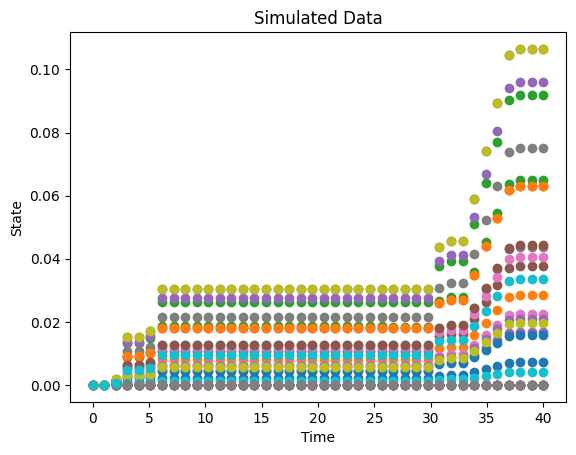

AttributeError: ignored

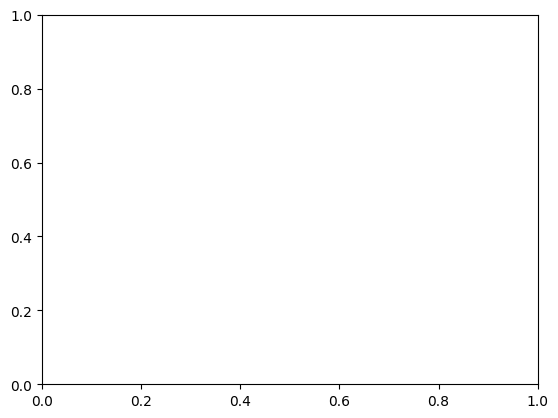

In [195]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
from typing import List, Union
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from typing import Tuple
from typing import Optional

class KWS(nn.Module):
    def __init__(self, L, fp, w, alpha, Ks, I, E):
        super().__init__()
        self.L = L
        self.fp = nn.Parameter(fp.unsqueeze(0))
        self.w = w
        self.alpha = alpha
        self.Ks = Ks
        self.I = I
        self.E = E

    def forward(self, t, h):
        #I = self.I.unsqueeze(1).expand_as(h)  ; print(f'I from def forward: {I.shape}')
        #E = self.E.unsqueeze(1).expand_as(h)  ; print(f'E from def forward: {E.shape}')
        dh_dt = (self.I - self.E) * (self.L * self.fp * self.w) - h * self.w * self.Ks * torch.sin(self.alpha)
        return dh_dt


class SimODEData(Dataset):
    def __init__(self, ts: List[torch.Tensor], states: List[torch.Tensor], true_model: Union[nn.Module, None] = None):
        self.ts = ts
        self.states = states
        self.true_model = true_model

    def __len__(self) -> int:
        return len(self.ts)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.ts[index], self.states[index]

def create_sim_dataset(model: nn.Module,
                       ts: torch.Tensor,
                       num_samples: int = 10,
                       sigma_noise: float = 0.1,
                       initial_conditions_default: torch.Tensor = torch.tensor([0.0, 0.0]),
                       sigma_initial_conditions: float = 0.1,
                       ) -> SimODEData:
    ts_list = [] 
    states_list = [] 
    dim = initial_conditions_default.shape[0]
    if I is None:
        I = torch.tensor(data['snowmelt (m/s)'].values[:len(ts)], dtype=torch.float32)

    for i in range(num_samples):
        x0 = sigma_initial_conditions * torch.randn((1, dim)).detach() + initial_conditions_default
        ys = odeint(model, x0, ts).squeeze(1).detach()
        ys += sigma_noise * torch.randn_like(ys)
        ys[0, :] = x0

        ts_list.append(ts)
        states_list.append(ys)

    return SimODEData(ts_list, states_list, true_model=model)


def plot_time_series(true_model: torch.nn.Module, # true underlying model for the simulated data
                     fit_model: torch.nn.Module, # model fit to the data
                     data: SimODEData, # data set to plot (scatter)
                     time_range: tuple = (0.0, 30.0), # range of times to simulate the models for
                     ax: plt.Axes = None, 
                     dyn_var_idx: int = 0,
                     title: str = "Model fits",
                     *args,
                     **kwargs) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot the true model and fit model on the same axes.
    """
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        
    
    ts = torch.linspace(time_range[0], time_range[1], 1000)
    ts_data, y_data = data

    initial_conditions = y_data[0, :].unsqueeze(0)
    sol_pred = odeint(fit_model, initial_conditions, ts, method='dopri5').detach().numpy()
    sol_true = odeint(true_model, initial_conditions, ts, method='dopri5').detach().numpy()
        
    ax.plot(ts, sol_pred[:,:,dyn_var_idx], color='skyblue', lw=2.0, label='Predicted', **kwargs);
    ax.scatter(ts_data.detach(), y_data[:,dyn_var_idx].detach(), color='black', s=30, label='Data',  **kwargs);
    ax.plot(ts, sol_true[:,:,dyn_var_idx], color='black', ls='--', lw=1.0, label='True model', **kwargs);
    ax.set_title(title);
    ax.set_xlabel("t");
    ax.set_ylabel("y");
    plt.legend();
    return fig, ax



    """def ode_func(t, h, I=None, E=None):
        index = min(int(t.item()), I.size(0) - 1)
        print(f"I.shape: {I.shape}")
        print(f"h.shape: {h.shape}")
        I_expanded = I[index].unsqueeze(0).expand_as(h)
        E_expanded = E.unsqueeze(0).expand_as(h.unsqueeze(0)).squeeze(0)
        print(f"I_expanded.shape: {I_expanded.shape}")
        print(f"E_expanded.shape: {E_expanded.shape}")
        model.I = I_expanded  # Update the model's input tensor
        model.E = E_expanded  # Update the model's E tensor
        return model.forward(t, h)"""
    def ode_func(t, h,I=I, E=E):
        index = min(int(t.item()), len(I) - 1)
        model.I = I[index].unsqueeze(0)  ;print(f"From ode_func model.I.shape: {model.I.shape}")
        return model.forward(t, h)
if __name__ == "__main__":
    # Define time points
    t_start = 0
    t_end = 40
    dt = 1  # Time step size
    num_steps = int((t_end - t_start) / dt)
    time_values = torch.linspace(t_start, t_end, num_steps)

    # Aquifer parameters of receiving snowmelt infiltration
    L = 10000                         # Length of the aquifer (m)
    w = 1                             # width of flow 
    Ks = torch.tensor(4.566e-5)       # Saturated Hydraulic Conductivity (m/s)
    Slope = torch.tensor(0.4)
    alpha = torch.atan(Slope)         # Calculate slope in radians
    fp_mean = torch.tensor(0.3)    # Mean porosity of the soil
    fp_std = torch.tensor(1.)     # Standard deviation of porosity

    # Define the model
    I = torch.tensor(data['snowmelt (m/s)'].values[:len(time_values)], dtype=torch.float32)
    E = torch.tensor(0.0)
    batch_size = 30

    # Define the initial condition
    h_initial = torch.tensor(0.0)

    def ode_func(t, h):
        index = min(int(t.item()), len(I) - 1)
        model.I = I[index].unsqueeze(0)  #; print(f'from ode_func model.I.shape: {model.I.shape}') # Add unsqueeze to match tensor shape
        return model.forward(t, h)

    # Create a list to store the solutions
    solutions = []

    # Create a batch of fp values with perturbations
    fp_values = fp_std * torch.randn((batch_size, 1)) + fp_mean
    fp_values = torch.clamp(fp_values, min=0)


    # Solve the ODE for each fp value separately
    for i in range(batch_size):
        model = KWS(L, fp_values[i], w, alpha, Ks, I, E)
        sol = odeint(ode_func, h_initial, time_values, method='rk4')
        solutions.append(sol)

    # Stack the solutions into a single tensor
    dataset = torch.stack(solutions, dim=0)

    # Test the dataset
    
    t, states = time_values[:dataset.shape[1]], dataset[:]
    
    # Plot
    fig, ax = plt.subplots()
    for i in range(batch_size):
      ax.scatter(t.detach().numpy(), states[i].detach().numpy(), label=f'Variable {i+1}')

    #ax.scatter(t.detach().numpy(), states.detach().numpy(), label='Variable')
    ax.set_xlabel('Time')
    ax.set_ylabel('State')
    ax.set_title('Simulated Data')
    #ax.legend()
    plt.show()

    # Training loop

    true_fp = torch.tensor(0.30)
    model = KWS(L, true_fp, w, alpha, Ks, I, E)
    #print(f'from model definition KWS() {model.I.shape}')
    #data_kws = odeint(ode_func, h_initial, time_values, method='rk4')
    sol = odeint(ode_func, h_initial, time_values, method='rk4')
    t, states = sol.t, sol
    fig, ax = plt.subplots()
    ax.scatter(t.detach().numpy(), states[:, i].detach().numpy(), label=f'Variable {i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('State')
    ax.set_title('Simulated Data')
    #ax.legend()
    plt.show()
    print(data_kws, data_kws.shape)
    # Create a wrong model 
    wrong_fp = torch.tensor(0.1)
    model = KWS(L, wrong_fp, w, alpha, Ks, I, E)
    sol = odeint(ode_func, h_initial, time_values, method='rk4')
    t, states = sol.t, sol
    fig, ax = plt.subplots()
    ax.scatter(t.detach().numpy(), states[:, i].detach().numpy(), label=f'Variable {i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('State')
    ax.set_title('Simulated Data')
    #ax.legend()
    plt.show()
    """plot_time_series(ode_func, 
                    kws_model,
                    data_kws,  # Extract the tensor of states from SimODEData
                    dyn_var_idx=1, 
                    title="KWS Model: Before Parameter Fits")"""
    #plot_time_series(ode_func, kws_model, data_kws, dyn_var_idx=1, title="KWS Model: Before Parameter Fits")
    


This just takes in a differential equation model with some initial states and generates some time-series data from it (and adds in some gaussian noise). This data is then passed into our custom dataset container. 

In [14]:
#| export


def plot_time_series(true_model: torch.nn.Module, # true underlying model for the simulated data
                     fit_model: torch.nn.Module, # model fit to the data
                     data: SimODEData, # data set to plot (scatter)
                     time_range: tuple = (0.0, 30.0), # range of times to simulate the models for
                     ax: plt.Axes = None, 
                     dyn_var_idx: int = 0,
                     title: str = "Model fits",
                     *args,
                     **kwargs) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot the true model and fit model on the same axes.
    """
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        
    vdp_model = VDP(mu = 0.10) 
    ts = torch.linspace(time_range[0], time_range[1], 1000)
    ts_data, y_data = data

    initial_conditions = y_data[0, :].unsqueeze(0)
    sol_pred = odeint(fit_model, initial_conditions, ts, method='dopri5').detach().numpy()
    sol_true = odeint(true_model, initial_conditions, ts, method='dopri5').detach().numpy()
        
    ax.plot(ts, sol_pred[:,:,dyn_var_idx], color='skyblue', lw=2.0, label='Predicted', **kwargs);
    ax.scatter(ts_data.detach(), y_data[:,dyn_var_idx].detach(), color='black', s=30, label='Data',  **kwargs);
    ax.plot(ts, sol_true[:,:,dyn_var_idx], color='black', ls='--', lw=1.0, label='True model', **kwargs);
    ax.set_title(title);
    ax.set_xlabel("t");
    ax.set_ylabel("y");
    plt.legend();
    return fig, ax

In [15]:
import matplotlib.pyplot as plt
from typing import Tuple

def plot_time_series(true_model: torch.nn.Module,
                     fit_model: torch.nn.Module,
                     data: SimODEData,
                     time_range: Tuple[float, float] = (0.0, 30.0),
                     ax: plt.Axes = None,
                     dyn_var_idx: int = 0,
                     title: str = "Model fits",
                     *args,
                     **kwargs) -> Tuple[plt.Figure, plt.Axes]:
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        
    ts_data, y_data = data[0], data[1]
    initial_conditions = y_data[0, :].unsqueeze(0)
    
    ts = torch.linspace(time_range[0], time_range[1], 1000)
    sol_pred = odeint(fit_model, initial_conditions, ts, method='dopri5').squeeze().detach().numpy()
    sol_true = odeint(true_model, initial_conditions, ts, method='dopri5').squeeze().detach().numpy()
    
    ax.plot(ts, sol_pred[:, dyn_var_idx], color='skyblue', lw=2.0, label='Predicted', **kwargs)
    ax.scatter(ts_data, y_data[:, dyn_var_idx], color='black', s=30, label='Data', **kwargs)
    ax.plot(ts, sol_true[:, dyn_var_idx], color='black', ls='--', lw=1.0, label='True model', **kwargs)
    ax.set_title(title)
    ax.set_xlabel("t")
    ax.set_ylabel("y")
    ax.legend()
    
    return fig, ax


In [16]:
#| export 

def plot_phase_plane(true_model: torch.nn.Module, # true underlying model for the simulated data
                     fit_model: torch.nn.Module, # model fit to the data
                     data: SimODEData, # data set to plot (scatter)
                     time_range: tuple = (0.0, 30.0), # range of times to simulate the models for
                     ax: plt.Axes = None, 
                     dyn_var_idx: tuple = (0,1),
                     title: str = "Model fits",
                     *args,
                     **kwargs) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot the true model and fit model on the same axes.
    """
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
        
    ts = torch.linspace(time_range[0], time_range[1], 1000)
    ts_data, y_data = data
    
    initial_conditions = y_data[0, :].unsqueeze(0)
    sol_pred = odeint(fit_model, initial_conditions, ts, method='dopri5').detach().numpy()
    sol_true = odeint(true_model, initial_conditions, ts, method='dopri5').detach().numpy()
    
    idx1, idx2 = dyn_var_idx
    
    ax.plot(sol_pred[:,:,idx1], sol_pred[:,:,idx2], color='skyblue', lw=1.0, label='Fit model');
    ax.scatter(y_data[:,idx1], y_data[:,idx2].detach(), color='black', s=30, label='Data');
    ax.plot(sol_true[:,:,idx1], sol_true[:,:,idx2], color='black', ls='--', lw=1.0, label='True model');
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(title)
    return fig, ax


## Training Loop

Next we will create a wrapper function for a pytorch training loop. Training means we want to update the model parameters to increase the alignment with the data ( or decrease the misalignment). 

One of the tricks for this from deep learning is to not use all the data before taking a gradient step. Part of this is necessity for using enormous datasets as you can't fit all of that data inside a GPU's memory, but this also can help the gradient descent algorithm avoid getting stuck in local minima.

The training loop in words: 
* Divide the dataset into mini-batches, these are subsets of your entire data set. Usually want to choose these randomly. 
* Iterate through the mini-batches, for each mini-batch:
    * Generate the predictions using the current model parameters
    * Calculate the loss (here we will use the mean squared error)
    * Calculate the gradients, using backpropagation.  
    * Update the parameters using a gradient descent step. Here we use the Adam optimizer.
* Each full pass through the dataset is called an epoch. 

Okay here is the code:

In [17]:

#| exports

def train(model: torch.nn.Module, # Model to train
          data: SimODEData, # Data to train on
          lr: float = 1e-2, # learning rate for the Adam optimizer
          epochs: int = 10, # Number of epochs to train for
          batch_size: int = 5, # Batch size for training
          method = 'rk4', # ODE solver to use
          step_size: float = 0.10, # for fixed diffeq solver set the step size
          show_every: int = 10, # How often to print the loss function message
          save_plots_every: Union[int,None] = None, # save a plot of the fit, to disable make this None
          model_name: str = "", #string for the model, used to reference the saved plots 
          *args: tuple, 
          **kwargs: dict
          ):
    
    # Create a data loader to iterate over the data. This takes in our dataset and returns batches of data
    trainloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    # Choose an optimizer. Adam is a good default choice as a fancy gradient descent
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Create a loss function this computes the error between the predicted and true values
    criterion = torch.nn.MSELoss() 
    
    for epoch in range(epochs):
        running_loss = 0.0 
        for batchdata in trainloader:
            optimizer.zero_grad() # reset gradients, famous gotcha in a pytorch training loop
            ts, states = batchdata # unpack the data 
            initial_state = states[:,0,:] # grab the initial state
            # Make the prediction and then flip the dimensions to be (batch, state_dim, time)
            # Pytorch expects the batch dimension to be first
            pred = odeint(model, initial_state, ts[0], method=method, options={'step_size': step_size}).transpose(0,1) 
            # Compute the loss
            loss = criterion(pred, states)
            # compute gradients
            loss.backward() 
            # update parameters
            optimizer.step() 
            running_loss += loss.item() # record loss
        if epoch % show_every == 0:
            print(f"Loss at {epoch}: {running_loss}")
        # Use this to save plots of the fit every save_plots_every epochs
        if save_plots_every is not None and epoch % save_plots_every == 0:
            with torch.no_grad():
                fig, ax = plot_time_series(data.true_model, model, data[0])
                ax.set_title(f"Epoch: {epoch}")
                fig.savefig(f"./tmp_plots/{epoch}_{model_name}_fit_plot")
                plt.close()



## Examples

### Fitting the VDP Oscillator

Let's use this training loop to recover the parameters from simulated VDP oscillator data.

In [18]:
true_mu = 0.30
model_sim = VDP(mu=true_mu)
ts_data = torch.linspace(0.0,10.0,10) 
data_vdp = create_sim_dataset(model_sim, 
                              ts = ts_data, 
                              num_samples=10, 
                              sigma_noise=0.01)

NameError: ignored

Let's create a model with the wrong parameter value and visualize the starting point.

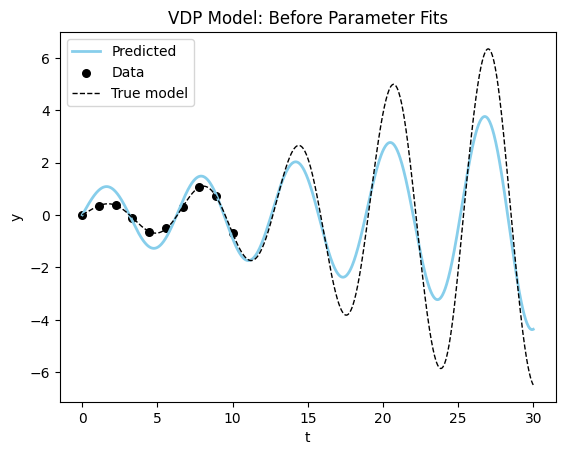

In [ ]:
vdp_model = VDP(mu = 0.10) 
plot_time_series(model_sim, 
                 vdp_model, 
                 data_vdp[0], 
                 dyn_var_idx=1, 
                 title = "VDP Model: Before Parameter Fits");

Now, we will use the training loop to fit the parameters of the VDP oscillator to the simulated data. 

In [ ]:

train(vdp_model, data_vdp, epochs=50, model_name="vdp");
print(f"After training: {vdp_model}, where the true value is {true_mu}")
print(f"Final Parameter Recovery Error: {vdp_model.mu - true_mu}")


Loss at 0: 0.13077779859304428
Loss at 10: 0.008475496899336576
Loss at 20: 0.0015564497443847358
Loss at 30: 0.00030691827123519033
Loss at 40: 0.00017259304877370596
After training:  mu: 0.3002389073371887, where the true value is 0.3
Final Parameter Recovery Error: 0.00023889541625976562


Not to bad! Let's see how the plot looks now...

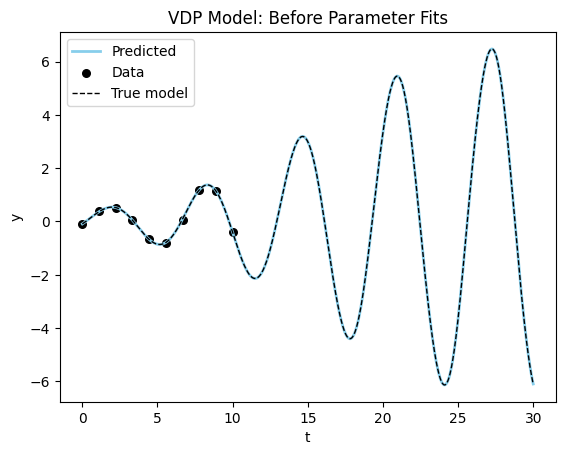

In [ ]:
plot_time_series(model_sim, vdp_model, data_vdp[0], dyn_var_idx=1, title = "VDP Model: Before Parameter Fits");

The plot confirms that we almost perfectly recovered the parameter. One more quick plot, where we plot the dynamics of the system in the phase plane (a parametric plot of the state variables). 

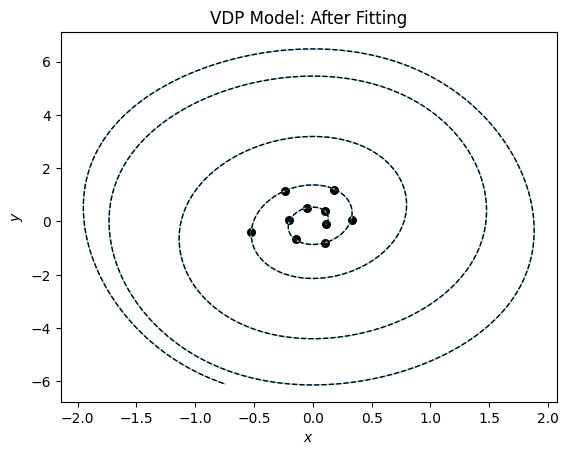

In [ ]:
plot_phase_plane(model_sim, vdp_model, data_vdp[0], title = "VDP Model: After Fitting");

### Lotka Voltera Equations 

Now lets adapt our methods to fit simulated data from the Lotka Voltera equations. 

In [ ]:

model_sim_lv = LotkaVolterra(1.5,1.0,3.0,1.0)
ts_data = torch.arange(0.0, 10.0, 0.1)
data_lv = create_sim_dataset(model_sim_lv, 
                              ts = ts_data, 
                              num_samples=10, 
                              sigma_noise=0.1,
                              initial_conditions_default=torch.tensor([2.5, 2.5]))


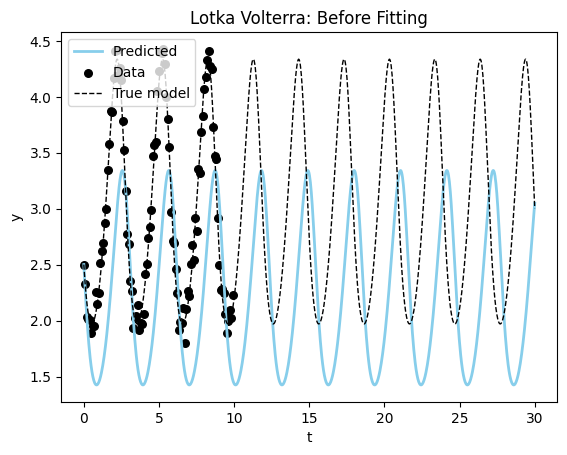

In [ ]:
model_lv = LotkaVolterra(alpha=1.6, beta=1.1,delta=2.7, gamma=1.2) 

plot_time_series(model_sim_lv, model_lv, data = data_lv[0], title = "Lotka Volterra: Before Fitting");

In [ ]:

train(model_lv, data_lv, epochs=60, lr=1e-2, model_name="lotkavolterra")
print(f"Fitted model: {model_lv}")
print(f"True model: {model_sim_lv}")

Loss at 0: 1.138481616973877
Loss at 10: 0.12903818115592003
Loss at 20: 0.04757681302726269
Loss at 30: 0.023409832268953323
Loss at 40: 0.021351825445890427
Loss at 50: 0.02119749877601862
Fitted model:  alpha: 1.5963928699493408,             beta: 1.0480306148529053,                 delta: 2.8150951862335205,                     gamma: 0.9381621479988098
True model:  alpha: 1.5,             beta: 1.0,                 delta: 3.0,                     gamma: 1.0


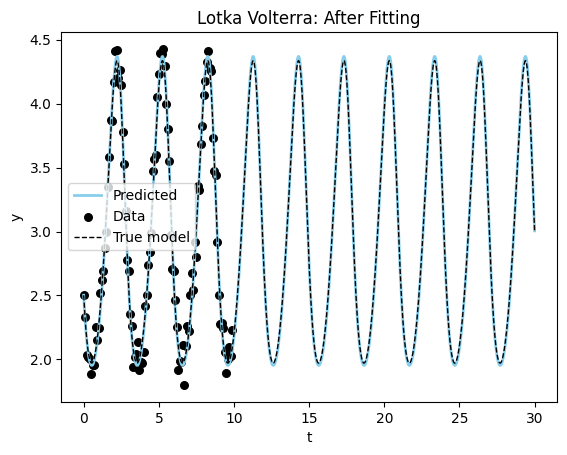

In [ ]:
plot_time_series(model_sim_lv, model_lv, data = data_lv[0], title = "Lotka Volterra: After Fitting");

Now let's visualize the results using a phase plane plot.

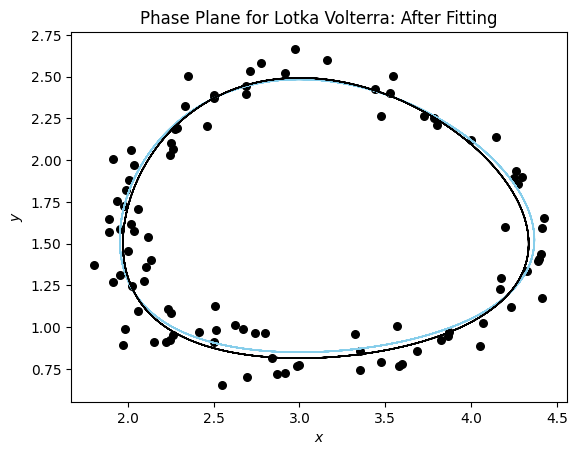

In [ ]:
plot_phase_plane(model_sim_lv, model_lv, data_lv[0], title= "Phase Plane for Lotka Volterra: After Fitting");

### Lorenz Equations

Finally, let's try to fit the Lorenz equations. 

In [ ]:
#| eval: false 

model_sim_lorenz = Lorenz(sigma=10.0, rho=28.0, beta=8.0/3.0)
ts_data = torch.arange(0, 10.0, 0.05)
data_lorenz = create_sim_dataset(model_sim_lorenz, 
                              ts = ts_data, 
                              num_samples=30, 
                              initial_conditions_default=torch.tensor([1.0, 0.0, 0.0]),
                              sigma_noise=0.01, 
                              sigma_initial_conditions=0.10)

(2.0, 15.0)

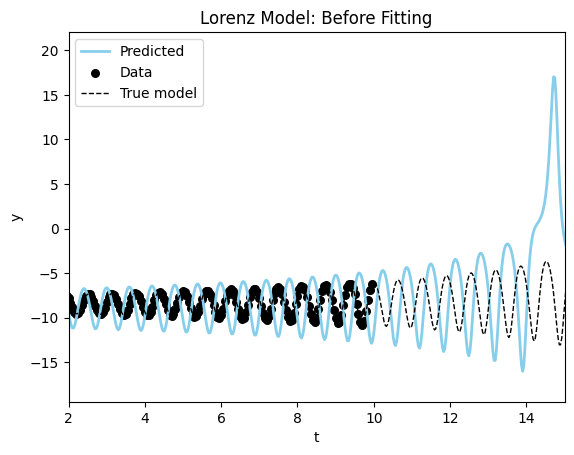

In [ ]:
#| eval: false 

lorenz_model = Lorenz(sigma=10.2, rho=28.2, beta=9.0/3) 
fig, ax = plot_time_series(model_sim_lorenz, lorenz_model, data_lorenz[0], title="Lorenz Model: Before Fitting");

ax.set_xlim((2,15))

In [ ]:
#|eval: false

train(lorenz_model, 
      data_lorenz, 
      epochs=300, 
      batch_size=5,
      method = 'rk4',
      step_size=0.05,
      show_every=50,
      lr = 1e-3)

Loss at 0: 112.65936279296875


Let's look at the results from the fitting procedure. Starting with a full plot of the dynamics.

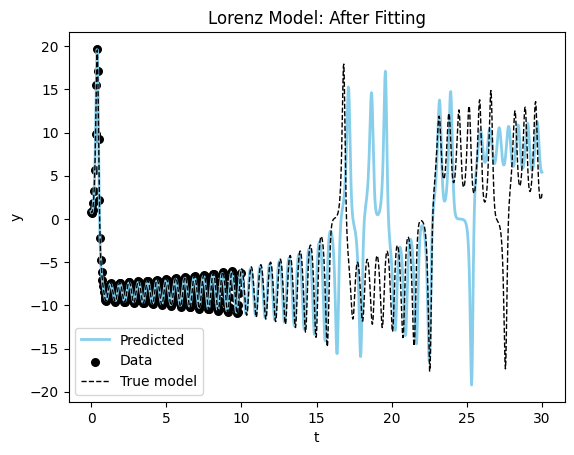

In [ ]:
#|eval: false

fig, ax = plot_time_series(model_sim_lorenz, lorenz_model, data_lorenz[0], title = "Lorenz Model: After Fitting"); 

Let's zoom in on the bulk of the data and see how the fit looks.

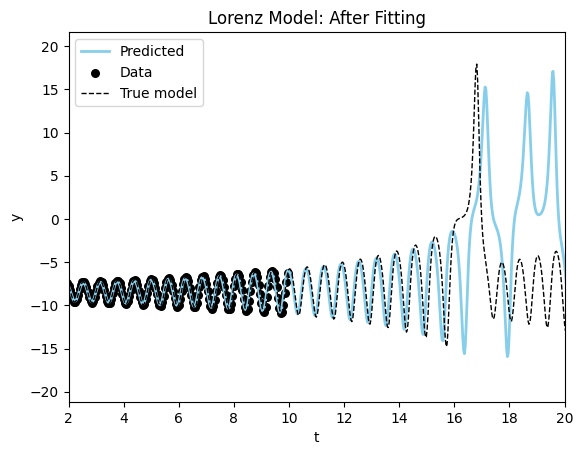

In [ ]:
#| eval: false
#| hide  

fig, ax = plot_time_series(model_sim_lorenz, lorenz_model, data_lorenz[0], title = "Lorenz Model: After Fitting"); 
ax.set_xlim((2,20));


You can see the model is very close to the true model for the data range. Now the phase plane plot.

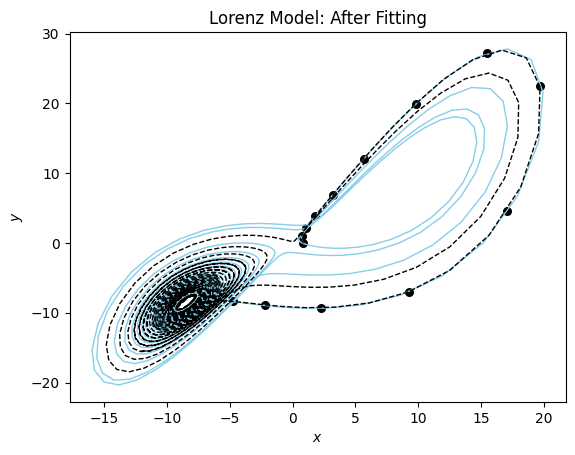

In [ ]:
#|eval: false

plot_phase_plane(model_sim_lorenz, lorenz_model, data_lorenz[0], title = "Lorenz Model: After Fitting", time_range=(0,20.0));

You can see that our fitted model performs well for t in [0,17] and then starts to diverge. 

# Intro to Neural Differential Equations 

This is great for the situation where we know the form of the equations on the right-hand-side, but what if we don't? Can we use this procedure to discover the model equations? 

This is much too big of a subject to cover in this post (stay tuned), but one of the biggest advantages of moving our differential equations models into the torch framework is that we can mix and match them with artificial neural network layers.

The simplest thing we can do is to replace the right-hand-side $f(y,t; \theta)$ with a neural network layer $l_\theta(y,t)$. These types of equations have been called a neural differential equations and it can be viewed as generalization of a recurrent neural network (citation). 

Let's do this for the our simple VDP oscillator system. 

Let's remake the simulated data, you will notice that I am creating longer time-series of the data, and more samples. Fitting a neural differential equation takes much more data and more computational power since we have many more parameters that need to be determined. 

In [ ]:
#|eval: false

# remake the data 
model_sim_vdp = VDP(mu=0.20)
ts_data = torch.linspace(0.0,30.0,100) # longer time series than the custom ode layer
data_vdp = create_sim_dataset(model_sim_vdp, 
                              ts = ts_data, 
                              num_samples=30, # more samples than the custom ode layer
                              sigma_noise=0.1,
                              initial_conditions_default=torch.tensor([0.50,0.10]))



In [ ]:
#| exports

class NeuralDiffEq(nn.Module):
    """ 
    Basic Neural ODE model
    """
    def __init__(self,
                 dim: int = 2, # dimension of the state vector
                 ) -> None:
        super().__init__()
        self.ann = nn.Sequential(torch.nn.Linear(dim, 8), 
                                 torch.nn.LeakyReLU(), 
                                 torch.nn.Linear(8, 16), 
                                 torch.nn.LeakyReLU(), 
                                 torch.nn.Linear(16, 32), 
                                 torch.nn.LeakyReLU(), 
                                 torch.nn.Linear(32, dim))
        
    def forward(self, t, state):
        return self.ann(state)

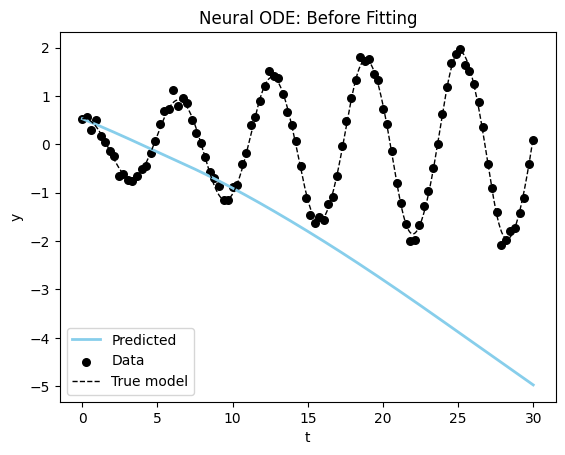

In [ ]:
#|eval: false

model_vdp_nde = NeuralDiffEq(dim=2) 
plot_time_series(model_sim_vdp, model_vdp_nde, data_vdp[0], title = "Neural ODE: Before Fitting");

You can see we start very far away for the correct solution, but then again we are injecting much less information into our model. Let's see if we can fit the model to get better results. 

In [ ]:
#|eval: false

train(model_vdp_nde, 
      data_vdp, 
      epochs=1500, 
      lr=1e-3, 
      batch_size=5,
      show_every=100,
      model_name = "nde")

Loss at 0: 84.39617252349854
Loss at 100: 84.34061241149902
Loss at 200: 73.75008296966553
Loss at 300: 3.4929964542388916
Loss at 400: 1.6555403769016266
Loss at 500: 0.7814530655741692
Loss at 600: 0.41551147401332855
Loss at 700: 0.3157300055027008
Loss at 800: 0.19066352397203445
Loss at 900: 0.15869349241256714
Loss at 1000: 0.12904016114771366
Loss at 1100: 0.23840919509530067
Loss at 1200: 0.1681726910173893
Loss at 1300: 0.09865255374461412
Loss at 1400: 0.09134986530989408


Visualizing the results, we can see that the model is able to fit the data and even extrapolate to the future (although it is not as good or fast as the specified model). 

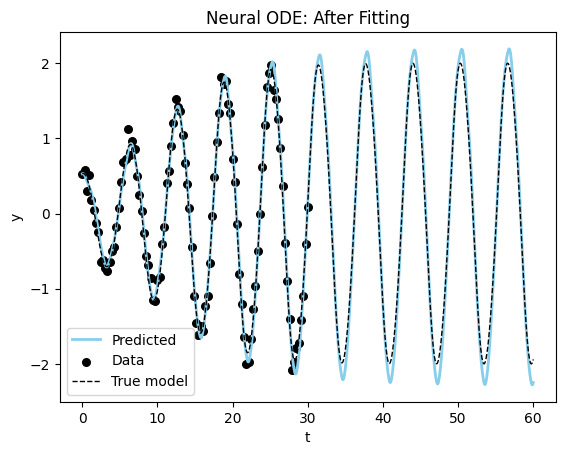

In [ ]:
#|eval: false 

plot_time_series(model_sim_vdp, model_vdp_nde, data_vdp[0], title = "Neural ODE: After Fitting", time_range=(0,60.0));

Now the phase plane plot of our neural differential equation model.

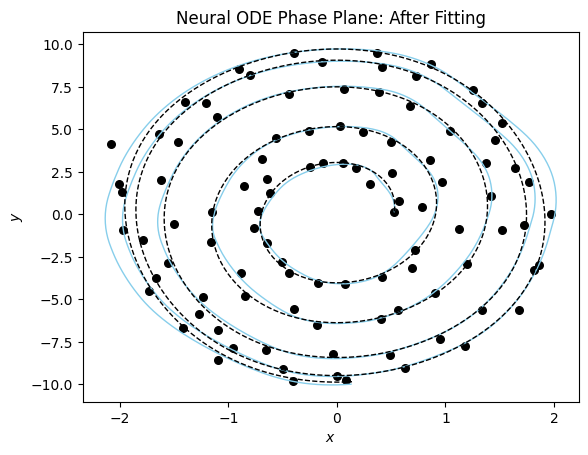

In [ ]:
#|eval: false

plot_phase_plane(model_sim_vdp, model_vdp_nde, data_vdp[0], title = "Neural ODE Phase Plane: After Fitting");

These models take a long time to train and more data to converge on a good fit. This makes sense since we are both trying to learn the model and the parameters at the same time. 

## Conclusions and Wrap-Up 

In this article I have demonstrated how we can use differential equation models within the pytorch ecosytem using the torchdiffeq package. The code from this article is available on <a> github </a> and can be opened directly to google colab for experimentation. You can also install the code from this article using pip (pip install paramfittorchdemo).


This post is an introduction in the future I will be writing more about the following topics:

* How to blend some mechanistic knowledge of the dynamics with deep learning. These have been called <a href="https://arxiv.org/abs/2001.04385"> universal differential equations </a> as they enable us to combine scientific knowledge with deep learning. This basically blends the two approaches together. 
* How to combine differential equation layers with other deep learning layers. 
* Model discovery: Can we recover the actual model equations from data? This uses tools like <a href="https://www.pnas.org/doi/10.1073/pnas.1906995116"> SINDy </a> to extract the model equations from data. 
* MLOps tools for managing the training of these models. This includes tools like <a href="https://mlflow.org/"> MLFlow </a>, <a href="https://wandb.ai/home"> Weights and Biases </a>, and <a href="https://pytorch.org/docs/stable/tensorboard.html"> Tensorboard </a>. 
* Anything else I hear back about from you! 

Happy modeling! 

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()